根据论文[Sutskever, Vinyals and Le (2014)](https://arxiv.org/abs/1409.3215)而来

In [1]:
import helper

看图：
![](https://d17h27t6h515a5.cloudfront.net/topher/2017/April/58e5893b_sequence-to-sequence-unrolled-encoder-decoder/sequence-to-sequence-unrolled-encoder-decoder.png)
在实际的word2word中，我们会对单词进行embedding操作，此处为了简单起见，我们直接就以数字代表输入了

In [2]:
x = [[5, 7, 8], [6, 3], [3], [1]]

In [3]:
xt, xlen = helper.batch(x)

In [4]:
xt # [max_time_len, batch_size]

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

In [5]:
xlen

[3, 2, 1, 1]

在处理中，我们会做一些特殊的处理

1. < PAD>: 在训练过程中，batch中每个句子长度会不同了，此时我们对于短的就直接用 < PAD> 来填充的
2. < EOS>: EOS代表的句子的结尾
3. < UNK>: 对于一些不常见的词汇，直接用UNK替换掉（例如人名）
4. < GO>: decode的第一个输入，告诉decode预测开始

## 定义模型
在定义模型的时候，我们需要确定的是 vocab_size ， input_embedding_size 和 encoder_hidden_units 和 decoder_hidden_units ，一旦修改得重新定义模型

In [6]:
import tensorflow as tf
import numpy as np

In [7]:
PAD = 0
EOS = 1
# UNK = 2
# GO  = 3

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

对于一个复杂的模型，我们想要去了解他，最好的方式就是看输入和输出，seq2seq的模型其输入和输出是：

- encoder_inputs int32 tensor is shaped [encoder_max_time, batch_size]
- decoder_targets int32 tensor is shaped [decoder_max_time, batch_size]

In [8]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

我们还需要定义的一个输入是decoder的输入
- decoder_inputs int32 tensor is shaped [decoder_max_time, batch_size]

In [9]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

在模型训练的时候，对于decoder的ouputs我们不会使用，而是直接使用decoder_targets作为decoder的输入，但是在做predictions的时候，我们却会使用decoder的输出作为下一个lstm的输入，这可能会引入 distribution shift from training to prediction.

## Embeddings
我们系统的输入encoder_inputs和decoder_inputs都是 [decoder_max_time, batch_size]的形状，但是我们 encoder 和 decoder 的输入形状都是要 [max_time, batch_size, input_embedding_size]， 因此我们需要对我们的是输入做一个word embedded

In [10]:
embeddings = tf.Variable(tf.truncated_normal([vocab_size, input_embedding_size], mean=0.0, stddev=0.1), dtype=tf.float32)

In [11]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [12]:
print(encoder_inputs_embedded)

Tensor("embedding_lookup:0", shape=(?, ?, 20), dtype=float32)


## encoder

In [13]:
encoder_cell = tf.contrib.rnn.BasicLSTMCell(encoder_hidden_units)

In [14]:
lstm_layers = 4
cell = tf.contrib.rnn.MultiRNNCell([encoder_cell] * lstm_layers)

In [15]:
# If `time_major == True`, this must be a `Tensor` of shape:
#       `[max_time, batch_size, ...]`, or a nested tuple of such
#       elements.
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(cell,encoder_inputs_embedded,dtype=tf.float32,time_major=True)
del encoder_outputs

此处我们直接删除了 encoder_outputs， 因为在这个场景中我们是不关注的，我们需要的是最后的 encoder_final_state，这又被称为 "thought vector"，如果没有引入attention机制，encoder_final_state 就是decoder的唯一输入，用他来作为decoder的init_state来解出decoder_targets。

>We hope that backpropagation through time (BPTT) algorithm will tune the model to pass enough information throught the thought vector for correct sequence output decoding.

In [16]:
print(encoder_final_state)

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 20) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 20) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_9:0' shape=(?, 20) dtype=float32>))


## decoder

In [17]:
decoder_cell = tf.contrib.rnn.BasicLSTMCell(decoder_hidden_units)
decoder = tf.contrib.rnn.MultiRNNCell([decoder_cell] * lstm_layers)
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder, decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

此处我们不关心decoder_inputs，而是关心decoder_outputs，对于decoder_outputs我们加一个fc，active_function=softmax，得到预测的单词

In [18]:
decoder_logits = tf.contrib.layers.fully_connected(decoder_outputs,vocab_size,activation_fn=None,
                                              weights_initializer = tf.truncated_normal_initializer(stddev=0.1),
                                              biases_initializer=tf.zeros_initializer())
# decoder_prediction = tf.argmax(decoder_logits,)

In [19]:
print(decoder_logits)

Tensor("fully_connected/Reshape_1:0", shape=(?, ?, 10), dtype=float32)


In [20]:
decoder_prediction = tf.argmax(decoder_logits,2) # 在这一步我突然意识到了axis的含义。。。表明的竟然是在哪个维度上求 argmax。

In [21]:
print(decoder_prediction)

Tensor("ArgMax:0", shape=(?, ?), dtype=int64)


对于RNN的输出，其shape是：[max_time, batch_size, hidden_units]，通过一个FC，将其映射为：[max_time, batch_size, vocab_size]

In [23]:
# learn_rate = tf.placeholder(tf.float32)
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

## 试运行
>deep learning is a game of shapes

当我们build graph的时候，如果shape错误就马上会提示，但是一些其他的shape检查，只有我们运行的时候才会发现错误

In [24]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch_ = [[6], [3, 4], [9, 8, 7]]

    batch_, batch_length_ = helper.batch(batch_)
    print('batch_encoded:\n' + str(batch_))

    din_, dlen_ = helper.batch(np.ones(shape=(3, 1), dtype=np.int32),
                                max_sequence_length=4)
    print('decoder inputs:\n' + str(din_))

    pred_ = sess.run(decoder_prediction,
        feed_dict={
            encoder_inputs: batch_,
            decoder_inputs: din_,
#             learn_rate:0.1,
        })
    print('decoder predictions:\n' + str(pred_))
    
print("build graph ok!")    

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[9 6 6]
 [9 6 2]
 [9 6 2]
 [9 9 4]]
build graph ok!


## 模拟训练
我们为了简单起见，产生了随机的输入序列，然后decoder原模原样的输出

In [25]:
batch_size = 100

batches = helper.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[7, 2, 9, 2, 2, 4, 4]
[6, 9, 8, 5, 2, 3]
[9, 3, 2, 4, 7]
[2, 5, 3, 3, 6, 8, 9]
[2, 4, 8, 5, 5, 3]
[2, 6, 3]
[3, 5, 2, 2]
[9, 5, 3]
[8, 5, 4, 2]
[4, 9, 5, 2, 4, 9]


In [26]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helper.batch(batch)
    decoder_targets_, _ = helper.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helper.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

当encoder_inputs 是[5, 6, 7]是decoder_targets是 [5, 6, 7, 1],1代表的是EOF，decoder_inputs则是 [1, 5, 6, 7]

In [27]:
loss_track = []

In [28]:
max_batches = 3001
batches_in_epoch = 1000

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    try:
        for batch in range(max_batches):
            fd = next_feed()
            _, l = sess.run([train_op, loss], fd)
            loss_track.append(l)

            if batch == 0 or batch % batches_in_epoch == 0:
                print('batch {}'.format(batch))
                print('  minibatch loss: {}'.format(sess.run(loss, fd)))
                predict_ = sess.run(decoder_prediction, fd)
                for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                    print('  sample {}:'.format(i + 1))
                    print('    input     > {}'.format(inp))
                    print('    predicted > {}'.format(pred))
                    if i >= 2:
                        break
                print()
    except KeyboardInterrupt:
        print('training interrupted')

batch 0
  minibatch loss: 2.301229476928711
  sample 1:
    input     > [4 8 3 3 4 8 0 0]
    predicted > [0 0 0 0 0 0 0 0 0]
  sample 2:
    input     > [4 8 7 8 4 3 0 0]
    predicted > [0 0 0 0 0 0 0 0 0]
  sample 3:
    input     > [6 4 3 0 0 0 0 0]
    predicted > [6 0 0 0 0 0 0 0 0]

batch 1000
  minibatch loss: 0.958212673664093
  sample 1:
    input     > [7 2 6 8 0 0 0 0]
    predicted > [7 7 3 3 1 0 0 0 0]
  sample 2:
    input     > [2 6 8 6 3 8 0 0]
    predicted > [3 3 6 6 6 6 1 0 0]
  sample 3:
    input     > [5 2 4 4 0 0 0 0]
    predicted > [5 4 4 4 1 0 0 0 0]

batch 2000
  minibatch loss: 0.3982703983783722
  sample 1:
    input     > [8 7 8 0 0 0 0 0]
    predicted > [8 7 8 1 0 0 0 0 0]
  sample 2:
    input     > [3 7 9 5 3 0 0 0]
    predicted > [3 7 8 5 9 1 0 0 0]
  sample 3:
    input     > [2 8 9 2 0 0 0 0]
    predicted > [2 3 9 2 1 0 0 0 0]

batch 3000
  minibatch loss: 0.27779871225357056
  sample 1:
    input     > [3 4 5 4 3 8 4 0]
    predicted > [3 4 4 5 

loss 0.2582 after 300100 examples (batch_size=100)


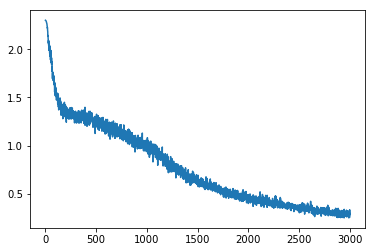

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))